# Import into Pandas from an ATLAS xAOD

This is a sample script that uses the ad-hoc analysis library to extract jet pt's from an ATLAS xAOD file.

## Setup and Config

In [1]:
fname = r"file://G:/mc16_13TeV/AOD.16300985._000011.pool.root.1"

In [2]:
%%time
from clientlib.DataSets import EventDataSet

Wall time: 701 ms


## Import the events into a Pandas array.

This requires docker installed. As this is a proof of principle, a lot of stuff is hardwired.

First thing we do is turn a dataset into an implicit stream of events.

In [3]:
%%time
f = EventDataSet(r"file://G:/mc16_13TeV/AOD.16300985._000011.pool.root.1")
events = f.AsATLASEvents()

Wall time: 0 ns


Next, we will select a stream of jet pt's. Here, these are every jet pt from every event strung together in a continuous stream.

- ``events`` is a sequence of events, one event after the next.
- ``SelectMany`` take each event, grabs the jets, and returns a sequence of jets. The result of the ``SelectMany`` is now a sequence of all jets in the file, from all events.
- ``Select`` takes each jet and replaces with the jet's pt. Now the sequence is of floats, representing the pT.

In [4]:
%%time
jet_pts = events \
            .SelectMany("lambda e: e.Jets('AntiKt4EMTopoJets')") \
            .Select("lambda j: j.pt()")

Wall time: 0 ns


And finally turn it into a pandas data frame. Each row has a single jet pt.

At this point no execution happens - a "future" is now setup with the pandas dataframe.

In [5]:
%%time
training_df = jet_pts.AsPandasDF(columns=['JetPt'])

Wall time: 0 ns


Finally, we turn it into something real. The following steps occur:

1. Some C++ code is written to access, read the xAOD jet's, create a ttree, and write it out.
1. A docker container with the ATLAS envrionment is started. The code and the data file location are mapped into it.
1. The code is compiled, and then run.
1. The output ROOT file is loaded with uproot and a DF is created.
1. All that temporary code and data is removed.

There is a fair amount of log file information that appears in the notebook engine window. At the moement that is not correctly redirected here - so you can see evidence of it running there.

In [6]:
%%time
df = training_df.value()

Wall time: 30.3 s


## The Dataframe

Now we can play with the dataframe as we wish.

In [7]:
df

,JetPt
0,257316.437500
1,253132.328125
2,47169.453125
3,39030.281250
4,30013.857422
5,26433.212891
6,25472.306641
7,25208.580078
8,24981.439453
9,24315.888672


In [8]:
%%time
import matplotlib.pyplot as plt

Wall time: 235 ms


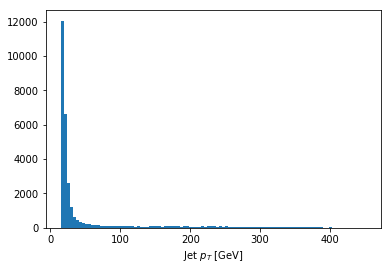

In [9]:
_ = plt.hist(df.JetPt/1000.0, bins=100)
_ = plt.xlabel("Jet $p_T$ [GeV]")

## Limitations

This is demo code. There are a number of limitations:

- Only "Jets" is understood (the only collection that can be accessed). Tho you can alter the name of the collection you want to access.
- Nothing more complex than "j.pt()" is allowed. While "j.eta()" is ok, "j.pt()/1000.0" is not allowed.
- Only a single query at a time is possible. So currently limited to a single column in the output data frame.